In [1]:
import numpy as np
import pandas as pd
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/irrigation_machine.csv'

try:
  df = pd.read_csv(dataset_path)
  print("Dataset loaded successfully!")
  print(df.head())
except FileNotFoundError:
  print(f"Error: File not found at {dataset_path}. Please check the path.")
except pd.errors.ParserError:
  print(f"Error: Could not parse the file at {dataset_path}. Please check the file format.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")


Dataset loaded successfully!
   Unnamed: 0  sensor_0  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
0           0       1.0       2.0       1.0       7.0       0.0       1.0   
1           1       5.0       1.0       3.0       5.0       2.0       2.0   
2           2       3.0       1.0       4.0       3.0       4.0       0.0   
3           3       2.0       2.0       4.0       3.0       5.0       0.0   
4           4       4.0       3.0       3.0       2.0       5.0       1.0   

   sensor_6  sensor_7  sensor_8  ...  sensor_13  sensor_14  sensor_15  \
0       1.0       4.0       0.0  ...        8.0        1.0        0.0   
1       1.0       2.0       3.0  ...        4.0        5.0        5.0   
2       1.0       6.0       0.0  ...        3.0        3.0        1.0   
3       3.0       2.0       2.0  ...        4.0        1.0        1.0   
4       3.0       1.0       1.0  ...        1.0        3.0        2.0   

   sensor_16  sensor_17  sensor_18  sensor_19  parcel_0  parcel_1  pa

In [5]:
missing_values = df.isnull().sum()
print(missing_values)

Unnamed: 0    0
sensor_0      0
sensor_1      0
sensor_2      0
sensor_3      0
sensor_4      0
sensor_5      0
sensor_6      0
sensor_7      0
sensor_8      0
sensor_9      0
sensor_10     0
sensor_11     0
sensor_12     0
sensor_13     0
sensor_14     0
sensor_15     0
sensor_16     0
sensor_17     0
sensor_18     0
sensor_19     0
parcel_0      0
parcel_1      0
parcel_2      0
dtype: int64


In [6]:
print(df.dtypes)

Unnamed: 0      int64
sensor_0      float64
sensor_1      float64
sensor_2      float64
sensor_3      float64
sensor_4      float64
sensor_5      float64
sensor_6      float64
sensor_7      float64
sensor_8      float64
sensor_9      float64
sensor_10     float64
sensor_11     float64
sensor_12     float64
sensor_13     float64
sensor_14     float64
sensor_15     float64
sensor_16     float64
sensor_17     float64
sensor_18     float64
sensor_19     float64
parcel_0        int64
parcel_1        int64
parcel_2        int64
dtype: object


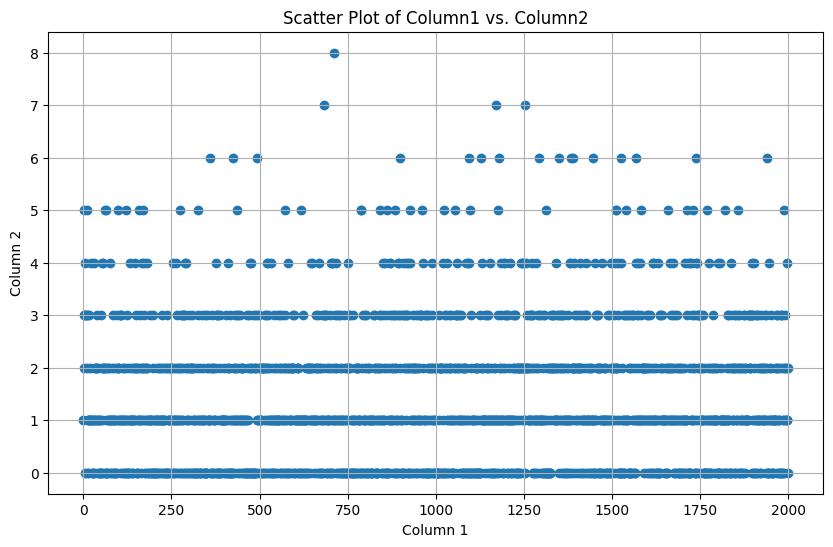

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Unnamed: 0'], df['sensor_0'])
plt.xlabel('Column 1')
plt.ylabel('Column 2')
plt.title('Scatter Plot of Column1 vs. Column2')
plt.grid(True)
plt.show()


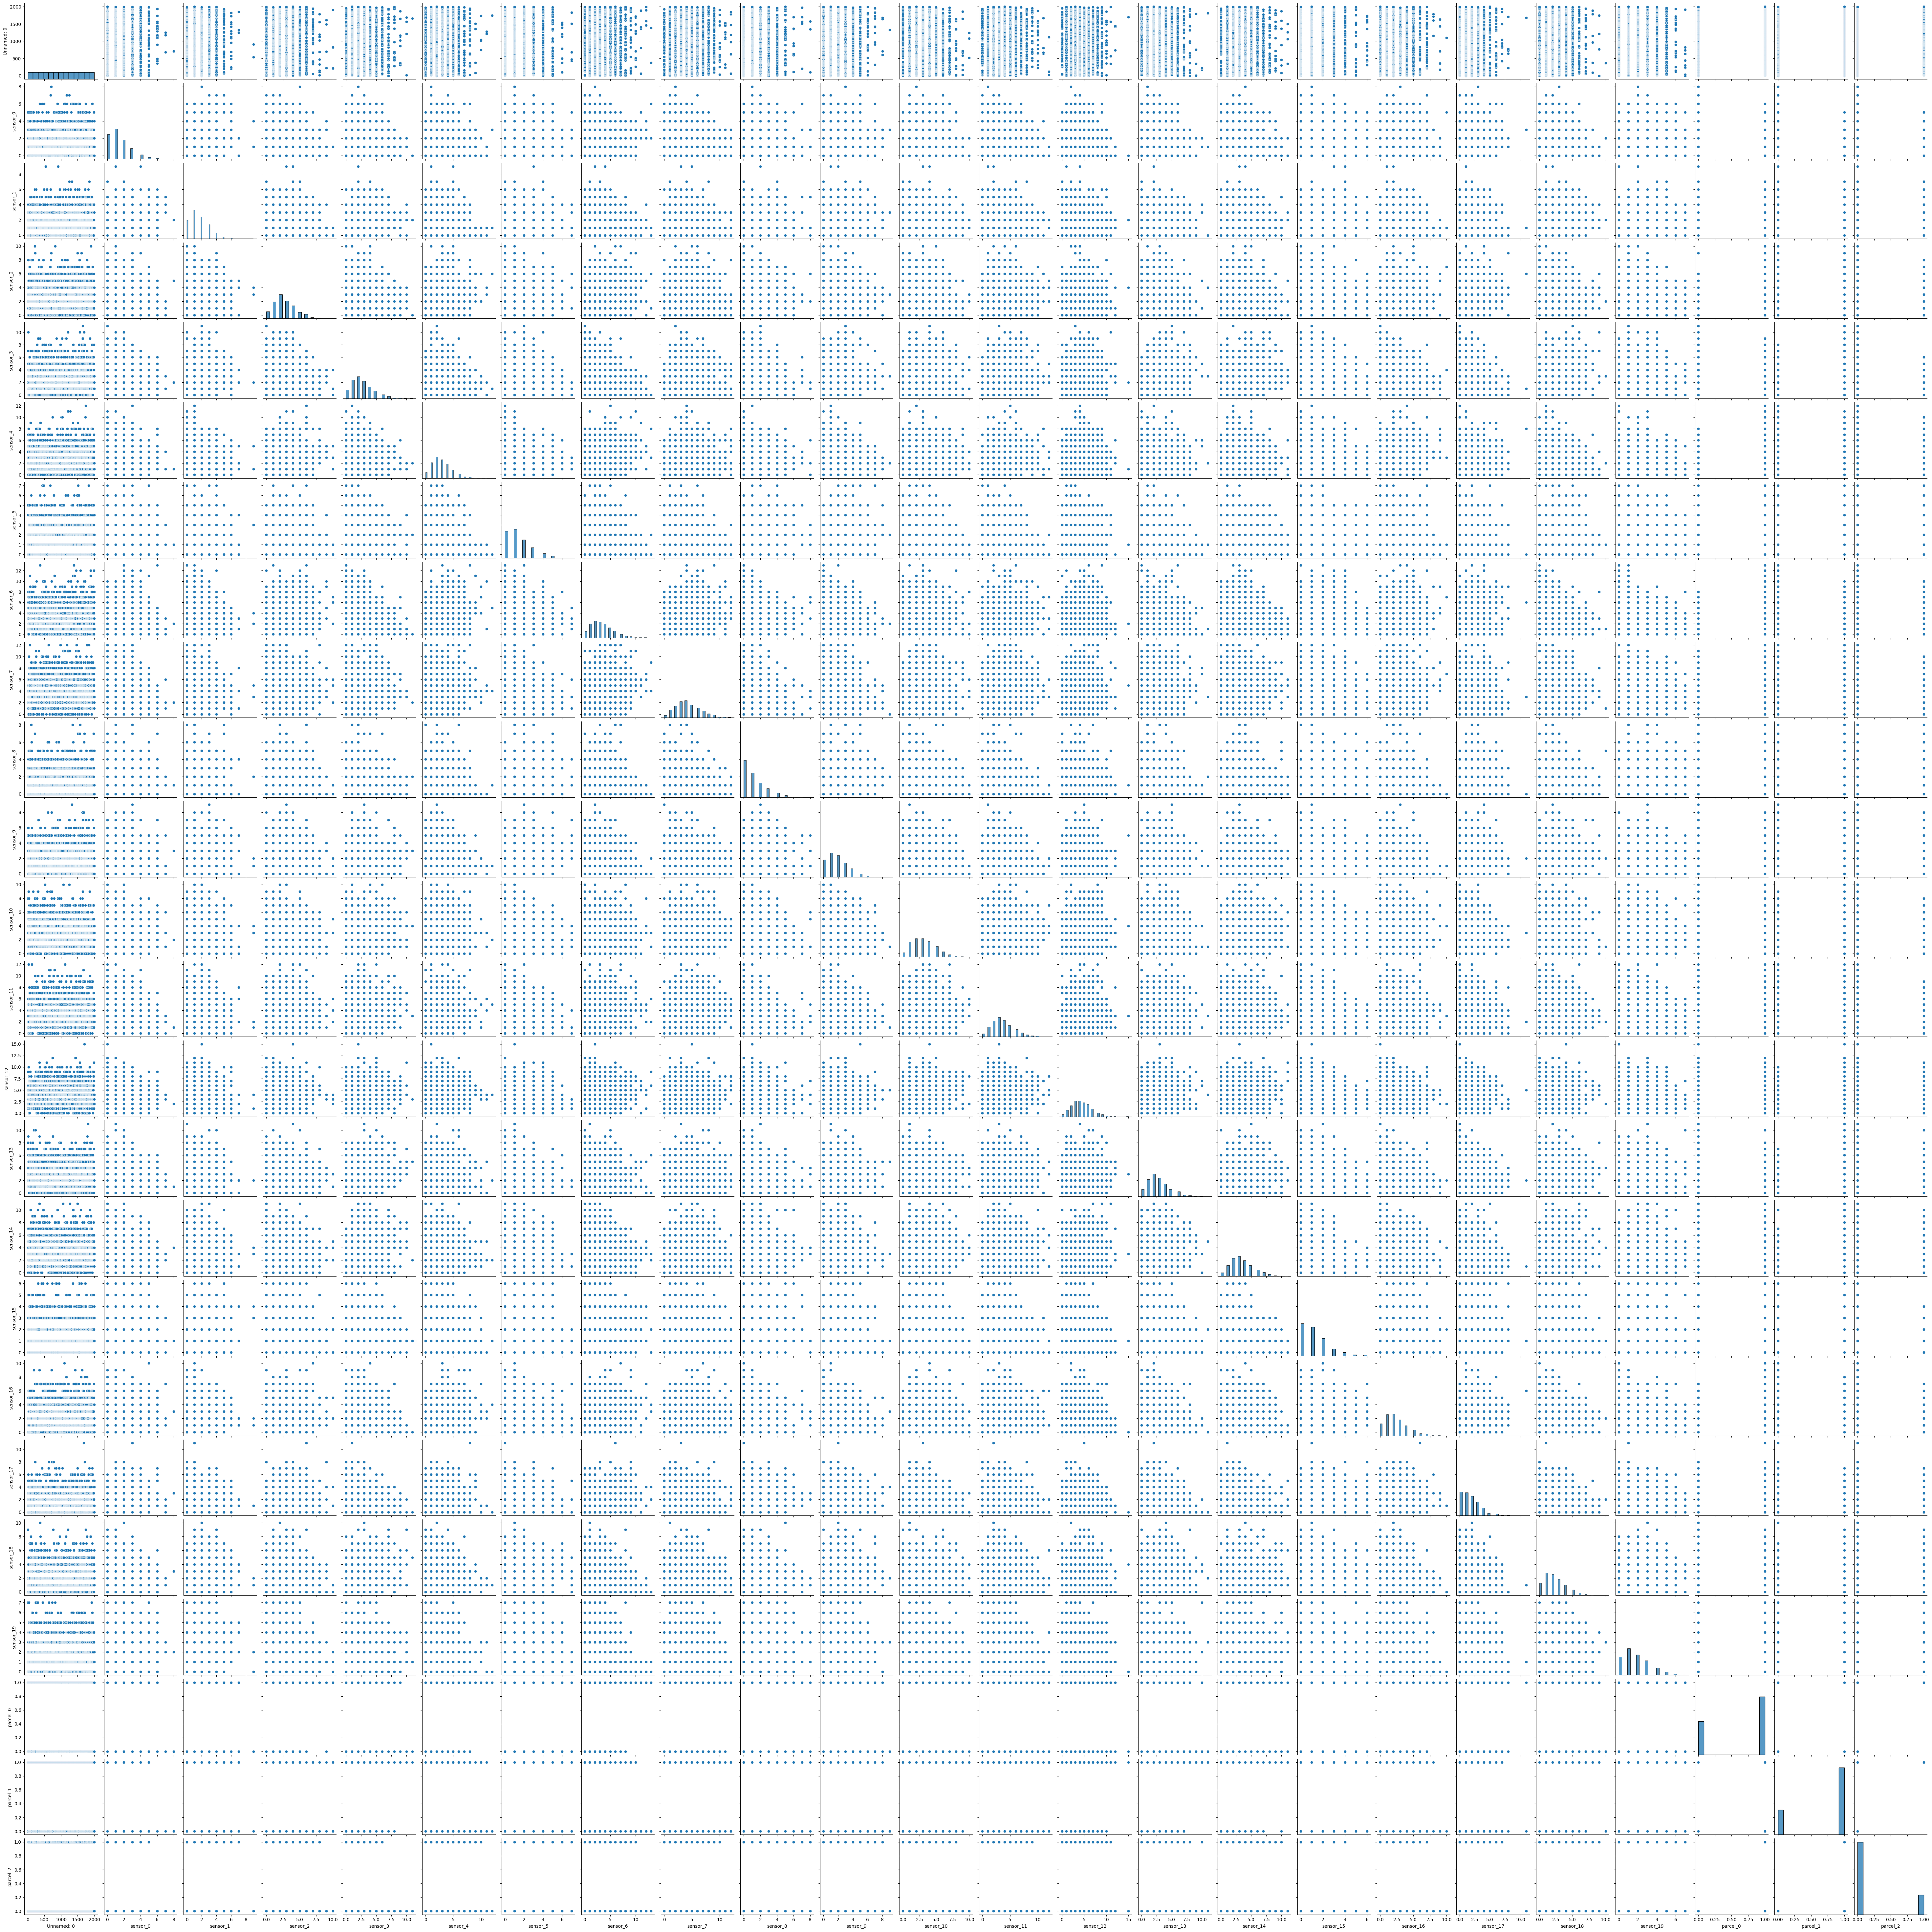

In [9]:
sns.pairplot(df)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

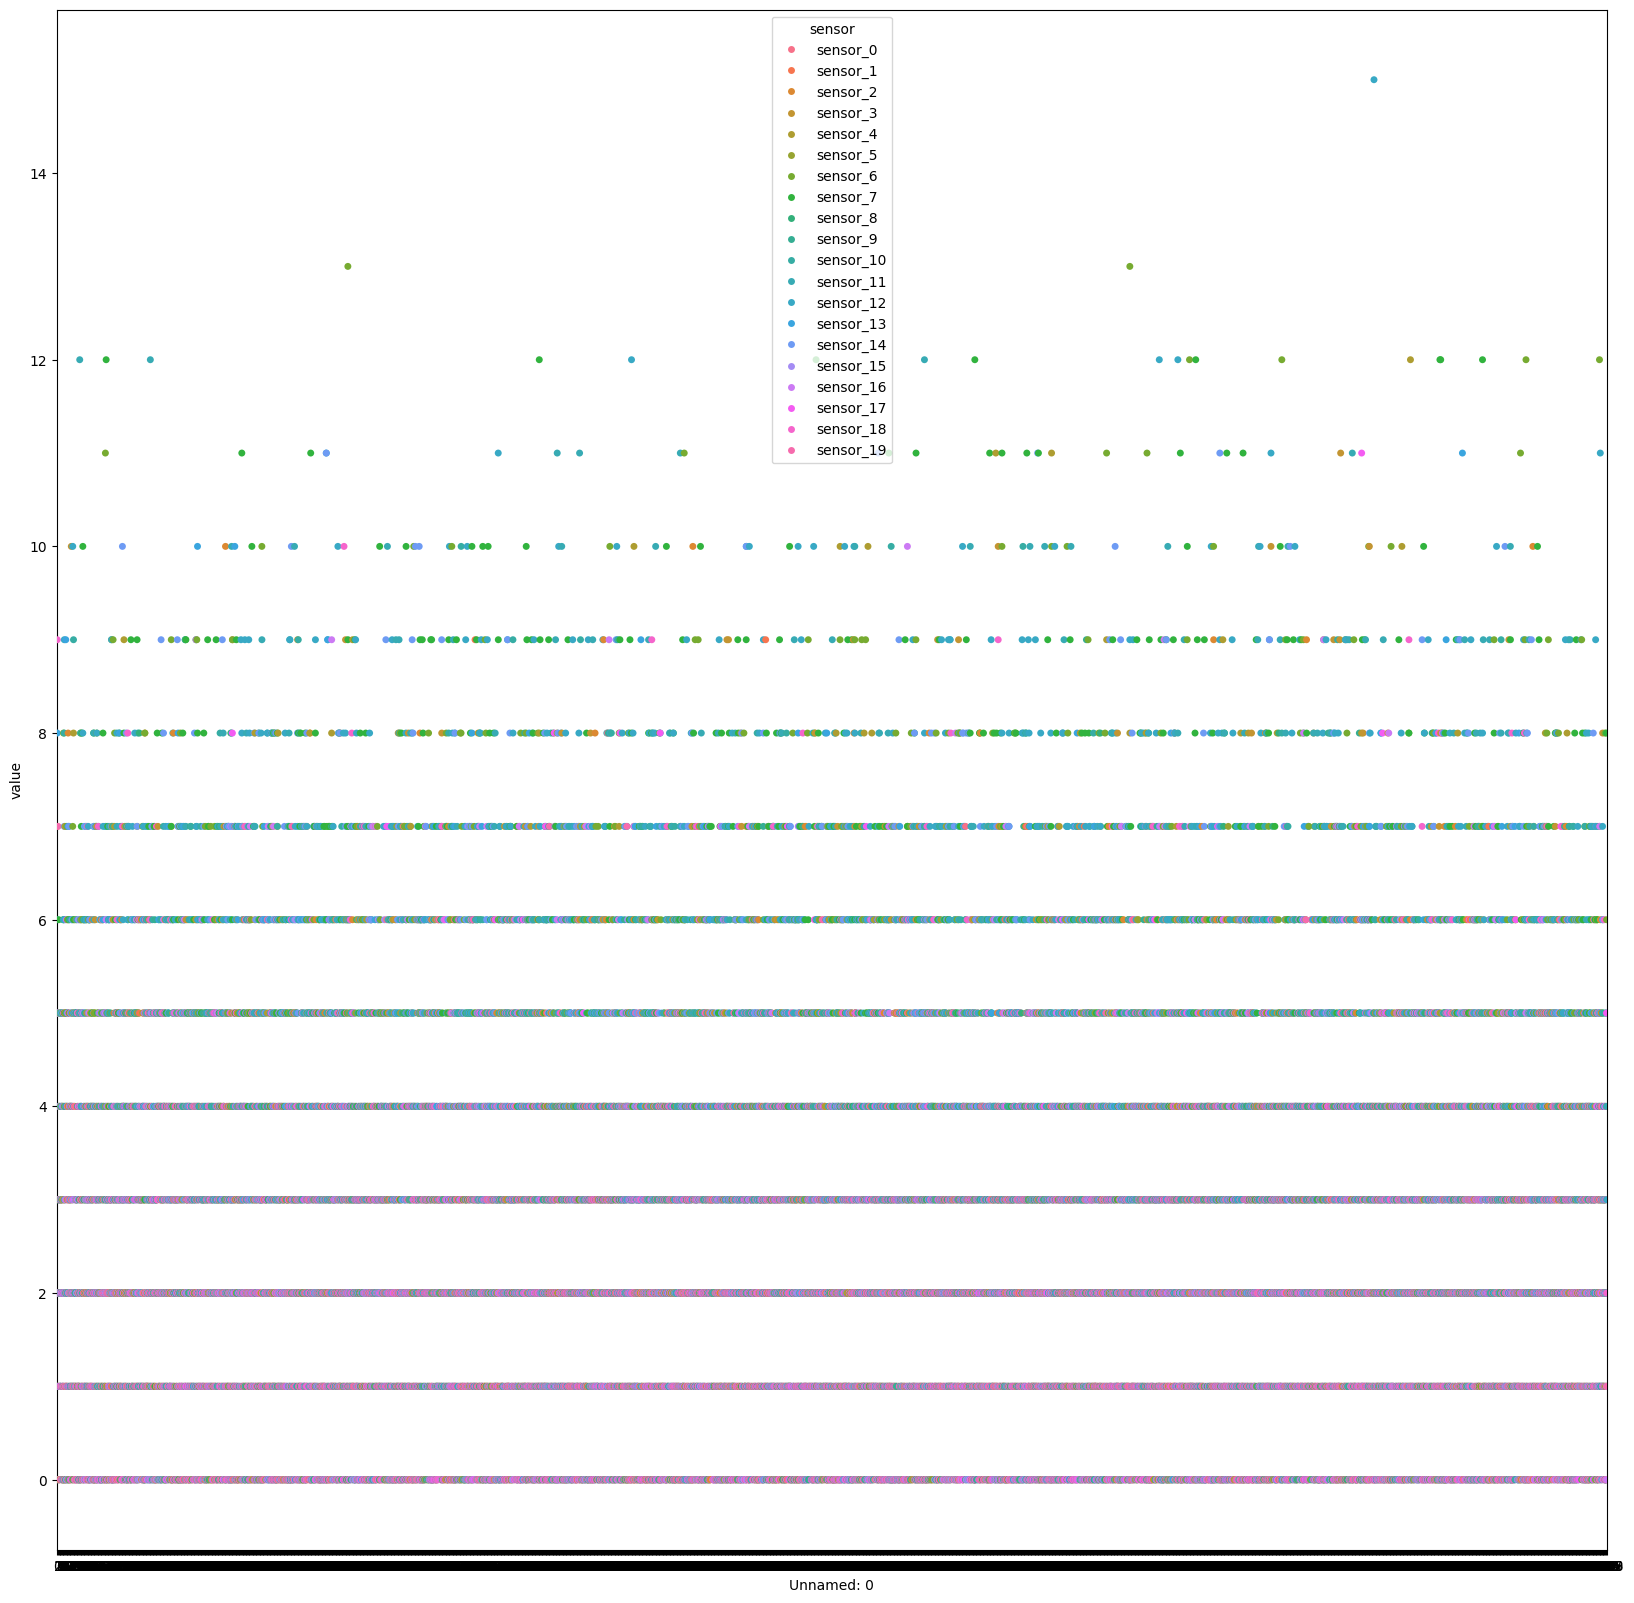

In [10]:
sensor_cols = [f'sensor_{i}' for i in range(20)]
df_melted  = pd.melt(df, id_vars=['Unnamed: 0'], value_vars=sensor_cols,
                     var_name='sensor', value_name='value')

plt.figure(figsize=(20,20))

sns.stripplot(data=df_melted, x='Unnamed: 0', y='value', hue='sensor')
plt.show

In [11]:
sensor_averages = df[sensor_cols].mean()


min_sensor = sensor_averages.idxmin()
min_average = sensor_averages.min()

print(f"The sensor with the lowest average value is {min_sensor} with an average of {min_average}")


The sensor with the lowest average value is sensor_15 with an average of 1.2065


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GRU, LSTM

In [13]:
y = df['Unnamed: 0']
x = df[sensor_cols]

In [14]:
df=df[pd.isnull(df['Unnamed: 0'])==False]

In [15]:
df

,Unnamed: 0,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,parcel_0,parcel_1,parcel_2
0,0,1.0,2.0,1.0,7.0,0.0,1.0,1.0,4.0,0.0,...,8.0,1.0,0.0,2.0,1.0,9.0,2.0,0,1,0
1,1,5.0,1.0,3.0,5.0,2.0,2.0,1.0,2.0,3.0,...,4.0,5.0,5.0,2.0,2.0,2.0,7.0,0,0,0
2,2,3.0,1.0,4.0,3.0,4.0,0.0,1.0,6.0,0.0,...,3.0,3.0,1.0,0.0,3.0,1.0,0.0,1,1,0
3,3,2.0,2.0,4.0,3.0,5.0,0.0,3.0,2.0,2.0,...,4.0,1.0,1.0,4.0,1.0,3.0,2.0,0,0,0
4,4,4.0,3.0,3.0,2.0,5.0,1.0,3.0,1.0,1.0,...,1.0,3.0,2.0,2.0,1.0,1.0,0.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,4.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,...,1.0,2.0,3.0,2.0,1.0,1.0,0.0,0,0,0
1996,1996,1.0,3.0,3.0,3.0,2.0,2.0,3.0,3.0,1.0,...,3.0,3.0,0.0,1.0,0.0,6.0,2.0,1,1,1
1997,1997,1.0,3.0,3.0,1.0,1.0,4.0,8.0,1.0,0.0,...,2.0,3.0,4.0,4.0,4.0,1.0,0.0,1,0,0
1998,1998,2.0,1.0,0.0,2.0,2.0,0.0,1.0,3.0,0.0,...,2.0,4.0,0.0,2.0,0.0,3.0,0.0,0,1,0


In [16]:
target_col = 'parcel_0'
if target_col not in df.columns:
    raise ValueError(f"Target column {target_col} not found in the dataframe.")

feature_cols = [col for col in df.columns if col.startswith('sensor')]
if len(feature_cols) == 0:
    raise ValueError('No sensor columns found in the dataframe to use as features.')

RANDOM_STATE = 42

In [17]:
X = df[feature_cols]
y = df[target_col]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [19]:
from tensorflow.keras.layers import GRU, Activation

timesteps = 1
X_train_reshaped = X_train.values.reshape((X_train.shape[0], timesteps, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], timesteps, X_test.shape[1]))

model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(timesteps, X_train.shape[1])))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32)


y_pred = model.predict(X_test_reshaped)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2102
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1245
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0923
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0981
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0897
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0755
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0790
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0745
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0792
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0737
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0641
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0678
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0716
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0660
Epoch 15/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0605
Epoc

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1254  
Test Loss: 0.11599844694137573
Test Accuracy: 0.865
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       146
           1       0.90      0.88      0.89       254

    accuracy                           0.86       400
   macro avg       0.85      0.86      0.86       400
weighted avg       0.87      0.86      0.87       400



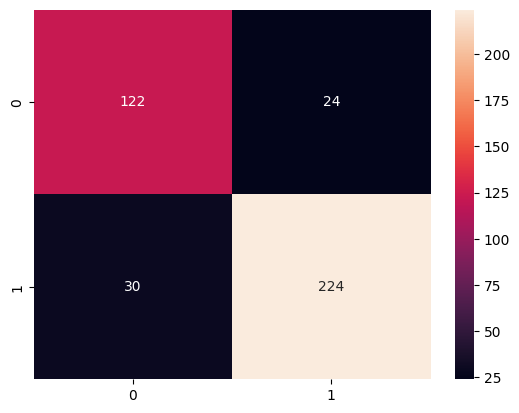

In [20]:
import matplotlib.pyplot as plt
loss = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {loss}")

threshold = 0.5

y_pred_class = (y_pred > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred_class)
print(f"Test Accuracy: {accuracy}")

print(classification_report(y_test, y_pred_class))
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()


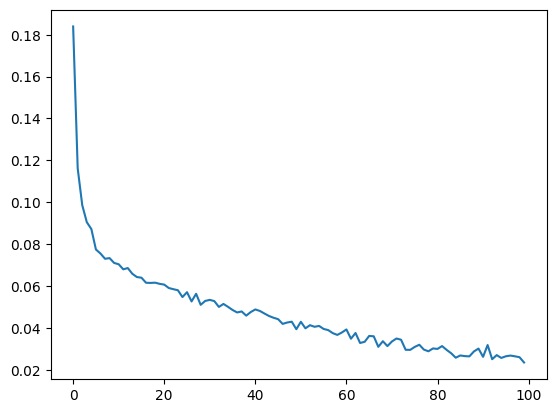

In [21]:
plt.plot(history.history['loss'], label='Training Loss')

In [22]:
import numpy as np
timesteps = 1
new_data = pd.DataFrame(np.random.rand(1,20), columns=[f'sensor_{i}' for i in range(20)])
new_data_reshaped = new_data.values.reshape((new_data.shape[0], timesteps, new_data.shape[1]))
prediction = model.predict(new_data_reshaped)

print(f"Prediction for sensor_15 input: {prediction}")

threshold = 0.5
predicted_class = (prediction > threshold).astype(int)
print(f"Predicted class for sensor_15 input (based on threshold): {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for sensor_15 input: [[0.9567126]]
Predicted class for sensor_15 input (based on threshold): [[1]]


In [23]:
timesteps = 1

for i in range(20):
  sensor_data = np.random.rand(1,1)

  new_data = pd.DataFrame(np.zeros((1,20)), columns=[f'sensor_{j}' for j in range(20)])

  new_data[f'sensor_{i}'] = sensor_data

  new_data_reshaped = new_data.values.reshape((new_data.shape[0], timesteps, new_data.shape[1]))

  prediction = model.predict(new_data_reshaped)

  threshold = 0.5
  predicted_class = (prediction > threshold).astype(int)

  print(f"Prediction for sensor_{i}: {prediction[0][0]}")
  print(f"Predicted class for sensor_{i}: {predicted_class[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for sensor_0: 0.012356678023934364
Predicted class for sensor_0: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for sensor_1: 0.011647026054561138
Predicted class for sensor_1: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for sensor_2: 0.03499333932995796
Predicted class for sensor_2: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for sensor_3: 0.008353549987077713
Predicted class for sensor_3: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for sensor_4: 0.033749762922525406
Predicted class for sensor_4: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for sensor_5: 0.026417391374707222
Predicted class for sensor_5: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for sensor_6: 0.02003498561680317
Predicted class for sensor_6: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for sensor_7: 0.012806123122572899
Predicted class for sensor_7: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for sensor_8: 0.006715100